# Application of FRANKEN-Z to Real Data

This notebook demonstrates an application of FRANKEN-Z to S16A Hyper Suprime-Cam (HSC) Subaru Strategic Program (SSP) survey data.

## Setup

Let's initialize the environment.

In [1]:
import sys # system commands
from scipy import stats # statistics
from scipy import special # special functions
from astropy.io import fits # reading fits files

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Importing HSC data...

In [2]:
# load observed data
data=fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/catalogs/hsc_s16a_combined_specz_highq_clean_errsim_train_v2.1.fits')[1].data

Importing FRANKEN-Z config files...

In [3]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])
Nf=filt.NFILTER

# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color

Initializing dust attenuation corrections...

In [4]:
aphot=10**(-0.4*c_[data['a_g'],data['a_r'],data['a_i'],data['a_z'],data['a_y']])

Initializing PSF flux...

In [5]:
flux_psf=c_[data['gflux_psf'],data['rflux_psf'],data['iflux_psf'],data['zflux_psf'],data['yflux_psf']]*aphot
err_psf=c_[data['gflux_psf_err'],data['rflux_psf_err'],data['iflux_psf_err'],data['zflux_psf_err'],data['yflux_psf_err']]*aphot
err_psf_wide=c_[data['gflux_psf_err_wide'],data['rflux_psf_err_wide'],data['iflux_psf_err_wide'],
                data['zflux_psf_err_wide'],data['yflux_psf_err_wide']]*aphot
mask_psf=(err_psf>0.)&isfinite(err_psf)
print 'Objects with missing values:',(mask_psf.sum(axis=1)<Nf).sum()

Objects with missing values: 3


Initializing cmodel flux...

In [6]:
flux_cmodel=c_[data['gcmodel_flux'],data['rcmodel_flux'],data['icmodel_flux'],data['zcmodel_flux'],data['ycmodel_flux']]*aphot
err_cmodel=c_[data['gcmodel_flux_err'],data['rcmodel_flux_err'],data['icmodel_flux_err'],
           data['zcmodel_flux_err'],data['ycmodel_flux_err']]*aphot
err_cmodel_wide=c_[data['gcmodel_flux_err_wide'],data['rcmodel_flux_err_wide'],data['icmodel_flux_err_wide'],
                data['zcmodel_flux_err_wide'],data['ycmodel_flux_err_wide']]*aphot
mask_cmodel=(err_cmodel>0.)&isfinite(err_cmodel)
print 'Objects with missing values:',(mask_cmodel.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Initializing cmodel_dev flux...

In [7]:
flux_cmodel_dev=c_[data['gcmodel_dev_flux'],data['rcmodel_dev_flux'],data['icmodel_dev_flux'],
                   data['zcmodel_dev_flux'],data['ycmodel_dev_flux']]*aphot
err_cmodel_dev=c_[data['gcmodel_dev_flux_err'],data['rcmodel_dev_flux_err'],data['icmodel_dev_flux_err'],
           data['zcmodel_dev_flux_err'],data['ycmodel_dev_flux_err']]*aphot
err_cmodel_dev_wide=c_[data['gcmodel_dev_flux_err_wide'],data['rcmodel_dev_flux_err_wide'],data['icmodel_dev_flux_err_wide'],
                data['zcmodel_dev_flux_err_wide'],data['ycmodel_dev_flux_err_wide']]*aphot
mask_cmodel_dev=(err_cmodel_dev>0.)&isfinite(err_cmodel_dev)
print 'Objects with missing values:',(mask_cmodel_dev.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Initializing cmodel_exp flux...

In [8]:
flux_cmodel_exp=c_[data['gcmodel_exp_flux'],data['rcmodel_exp_flux'],data['icmodel_exp_flux'],
                   data['zcmodel_exp_flux'],data['ycmodel_exp_flux']]*aphot
err_cmodel_exp=c_[data['gcmodel_exp_flux_err'],data['rcmodel_exp_flux_err'],data['icmodel_exp_flux_err'],
           data['zcmodel_exp_flux_err'],data['ycmodel_exp_flux_err']]*aphot
err_cmodel_exp_wide=c_[data['gcmodel_exp_flux_err_wide'],data['rcmodel_exp_flux_err_wide'],data['icmodel_exp_flux_err_wide'],
                data['zcmodel_exp_flux_err_wide'],data['ycmodel_exp_flux_err_wide']]*aphot
mask_cmodel_exp=(err_cmodel_exp>0.)&isfinite(err_cmodel_exp)
print 'Objects with missing values:',(mask_cmodel_exp.sum(axis=1)<Nf).sum()

Objects with missing values: 0


Initializing afterburner flux...

In [9]:
flux_afterburner=c_[data['gparent_flux_convolved_2_1'],data['rparent_flux_convolved_2_1'],data['iparent_flux_convolved_2_1'],
                   data['zparent_flux_convolved_2_1'],data['yparent_flux_convolved_2_1']]*aphot
err_afterburner=c_[data['gflux_aperture15_err'],data['rflux_aperture15_err'],data['iflux_aperture15_err'],
                   data['zflux_aperture15_err'],data['yflux_aperture15_err']]*aphot
err_afterburner_wide=c_[data['gflux_aperture15_err_wide'],data['rflux_aperture15_err_wide'],data['iflux_aperture15_err_wide'],
                        data['zflux_aperture15_err_wide'],data['yflux_aperture15_err_wide']]*aphot
mask_afterburner=(err_afterburner>0.)&isfinite(err_afterburner)
print 'Objects with missing values:',(mask_afterburner.sum(axis=1)<Nf).sum()

Objects with missing values: 3


Initializing shape information...

In [10]:
shape_sdss=c_[data['gshape_sdss_11'],data['gshape_sdss_12'],data['gshape_sdss_22'],
              data['rshape_sdss_11'],data['rshape_sdss_12'],data['rshape_sdss_22'],
              data['ishape_sdss_11'],data['ishape_sdss_12'],data['ishape_sdss_22'],
              data['zshape_sdss_11'],data['zshape_sdss_12'],data['zshape_sdss_22'],
              data['yshape_sdss_11'],data['yshape_sdss_12'],data['yshape_sdss_22']]
err_sdss=c_[data['gshape_sdss_err_11_11'],data['gshape_sdss_err_12_12'],data['gshape_sdss_err_22_22'],
            data['rshape_sdss_err_11_11'],data['rshape_sdss_err_12_12'],data['rshape_sdss_err_22_22'],
            data['ishape_sdss_err_11_11'],data['ishape_sdss_err_12_12'],data['ishape_sdss_err_22_22'],
            data['zshape_sdss_err_11_11'],data['zshape_sdss_err_12_12'],data['zshape_sdss_err_22_22'],
            data['yshape_sdss_err_11_11'],data['yshape_sdss_err_12_12'],data['yshape_sdss_err_22_22']]
err_sdss_wide=c_[data['gshape_sdss_err_11_11_wide'],data['gshape_sdss_err_12_12_wide'],data['gshape_sdss_err_22_22_wide'],
                 data['rshape_sdss_err_11_11_wide'],data['rshape_sdss_err_12_12_wide'],data['rshape_sdss_err_22_22_wide'],
                 data['ishape_sdss_err_11_11_wide'],data['ishape_sdss_err_12_12_wide'],data['ishape_sdss_err_22_22_wide'],
                 data['zshape_sdss_err_11_11_wide'],data['zshape_sdss_err_12_12_wide'],data['zshape_sdss_err_22_22_wide'],
                 data['yshape_sdss_err_11_11_wide'],data['yshape_sdss_err_12_12_wide'],data['yshape_sdss_err_22_22_wide']]
mask_sdss=(err_sdss>0.)&isfinite(err_sdss)

size_sdss=shape_sdss[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]]-shape_sdss[:,[1,4,7,10,13]]**2
size_sdss_err=((shape_sdss[:,[0,3,6,9,12]]*err_sdss[:,[2,5,8,11,14]])**2
               +(err_sdss[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]])**2
               +(2*shape_sdss[:,[1,4,7,10,13]]*err_sdss[:,[1,4,7,10,13]])**2)**0.5
size_sdss_err_wide=((shape_sdss[:,[0,3,6,9,12]]*err_sdss_wide[:,[2,5,8,11,14]])**2
                    +(err_sdss_wide[:,[0,3,6,9,12]]*shape_sdss[:,[2,5,8,11,14]])**2
                    +(2*shape_sdss[:,[1,4,7,10,13]]*err_sdss_wide[:,[1,4,7,10,13]])**2)**0.5

print 'Objects with missing values:',(mask_sdss.sum(axis=1)<Nf*3).sum()

Objects with missing values: 33426


Extracting redshifts...

In [11]:
z,ze,zt,zs=data['redshift'],data['redshift_err'],data['redshift_type'],data['redshift_source']
ze[ze<0]=0.

Initializing general catalog features...

In [12]:
Nobs=len(data) # number of objects
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(err_cmodel,axis=0) # "background" skynoise (used for consistent mappings)
mag_cmodel,magerr_cmodel=fz.asinh_mag_map(flux_cmodel,err_cmodel_wide,
                                          zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
depth=data['depth']
cv=data['crossval_sample']
cv_weights=data['crossval_weights']

Nfolds=max(cv)

In [13]:
lzidx,lzeidx=rdict.fit(log(1+z),ze/(1+z)) # discretize redshifts
midx,meidx=mdict.fit(mag_cmodel,magerr_cmodel) # discretize magnitudes

## Diagnostics

Let's make some preliminary plots to see what we're dealing with.

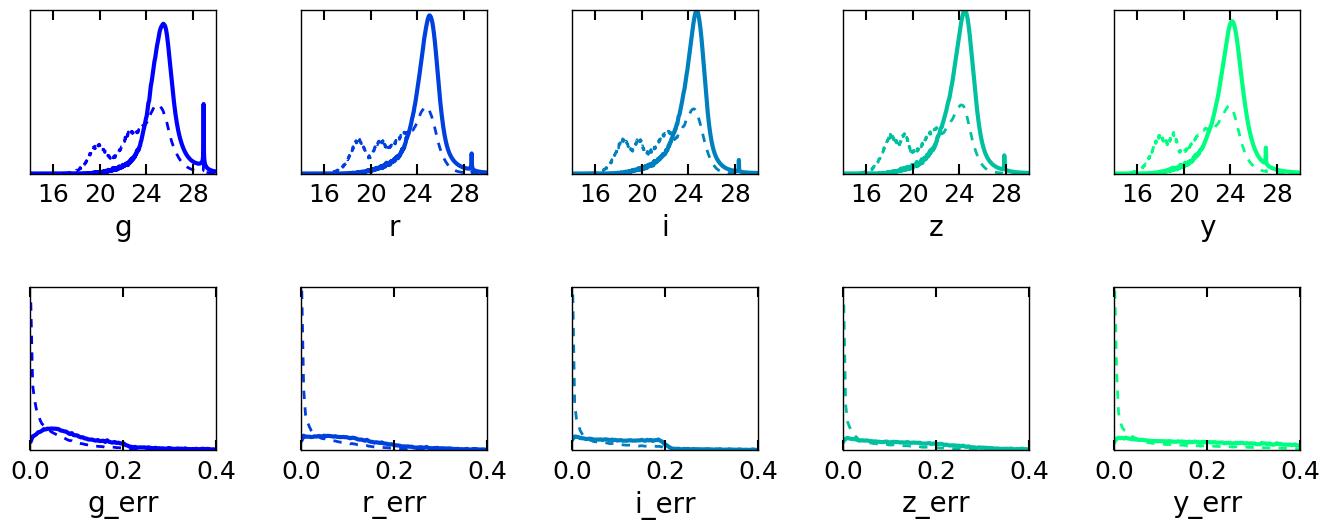

In [16]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,Nf)) # filter colors
figure(figsize=(14,6))
for i in xrange(Nf):
    subplot(2,Nf,i+1)
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,midx[:,i],meidx[:,i],ones(Nobs),
                            mdict.grid,mdict.delta,mdict.Ngrid)
    plot(mdict.grid,mag_pdf,lw=2,color=fcolors[i],linestyle='--')
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,midx[:,i],meidx[:,i],cv_weights,
                            mdict.grid,mdict.delta,mdict.Ngrid)
    plot(mdict.grid,mag_pdf,lw=3,color=fcolors[i])
    xlim([14,30])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(filt.filters[i],fontsize=20)
    tight_layout()
    subplot(2,Nf,i+1+Nf)
    h,bins=histogram(magerr_cmodel[:,i],normed=True,range=[0,0.4],bins=100)
    plot((bins[:-1]+bins[1:])/2.,h,lw=2,color=fcolors[i],linestyle='--')
    h,bins=histogram(magerr_cmodel[:,i],normed=True,range=[0,0.4],bins=100,weights=cv_weights)
    plot((bins[:-1]+bins[1:])/2.,h,lw=3,color=fcolors[i])
    xticks(linspace(0,0.4,3),fontsize=18)
    xlabel(filt.filters[i]+'_err',fontsize=20)
    yticks([])
    tight_layout()

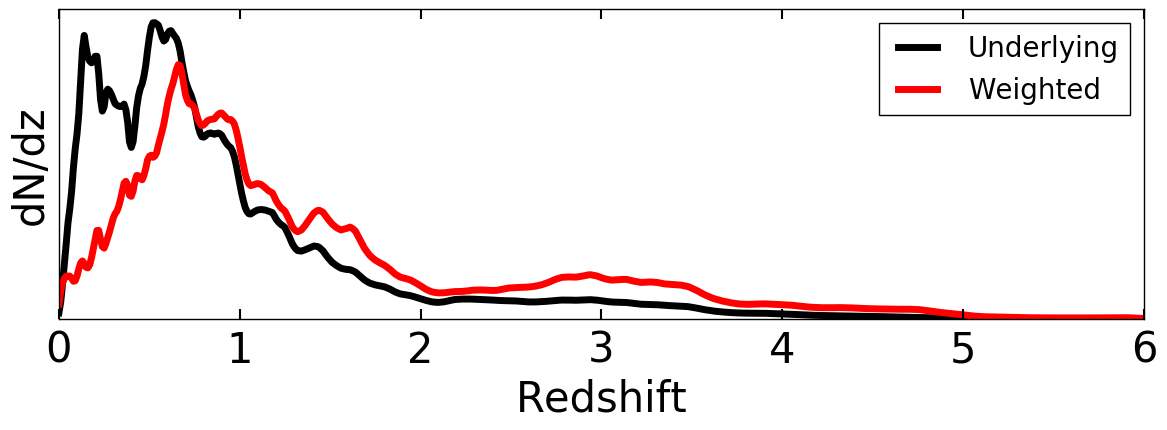

In [17]:
figure(figsize=(14,4))

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,ones(Nobs),rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='red',label='Weighted')

legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

## Initial Tests

Let's run some initial tests using each individual set of fluxes to see which (if any) appears to perform best. Since we're just trying to gain some intuition, we'll just choose one of the original folds to run some tests on.

In [15]:
train_sel=cv<5
test_sel=cv==5
lzidx_train,lzeidx_train=lzidx[train_sel],lzeidx[train_sel]
lzidx_test,lzeidx_test=lzidx[test_sel],lzeidx[test_sel]

Ntrain=train_sel.sum()
Ntest=test_sel.sum()
print 'Ntrain:',Ntrain
print 'Ntest:',Ntest

Ntrain: 305591
Ntest: 76425


### Cmodel Fluxes

In [19]:
p1,v1,m1=flux_cmodel[train_sel],square(err_cmodel_wide[train_sel]),mask_cmodel[train_sel]
p2,v2,m2=flux_cmodel[test_sel],square(err_cmodel_wide[test_sel]),mask_cmodel[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [20]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


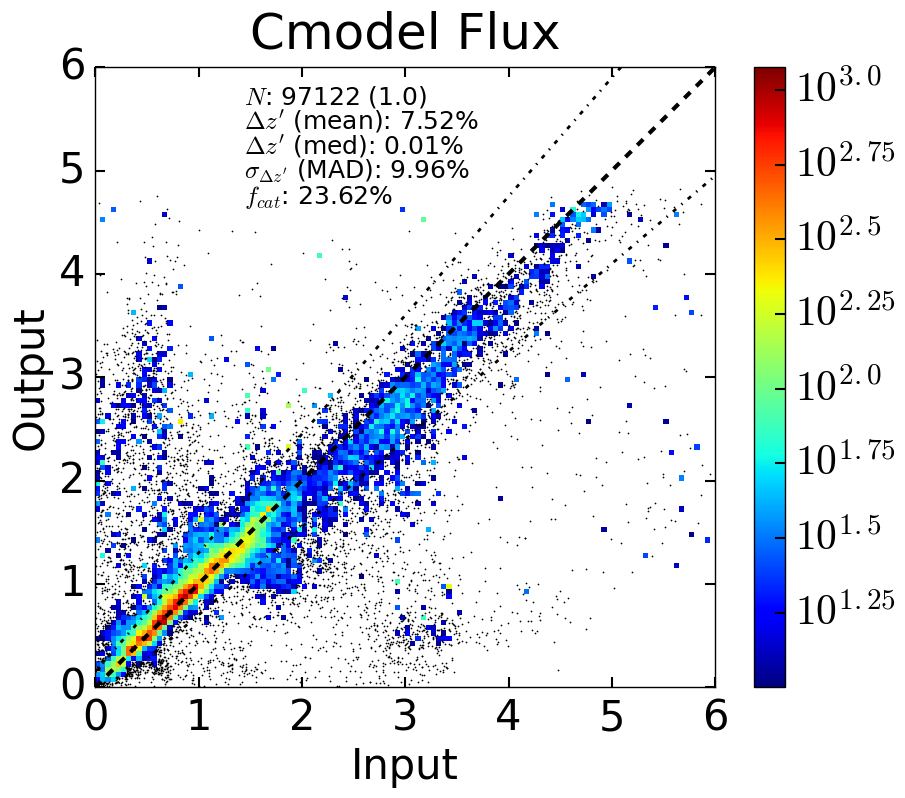

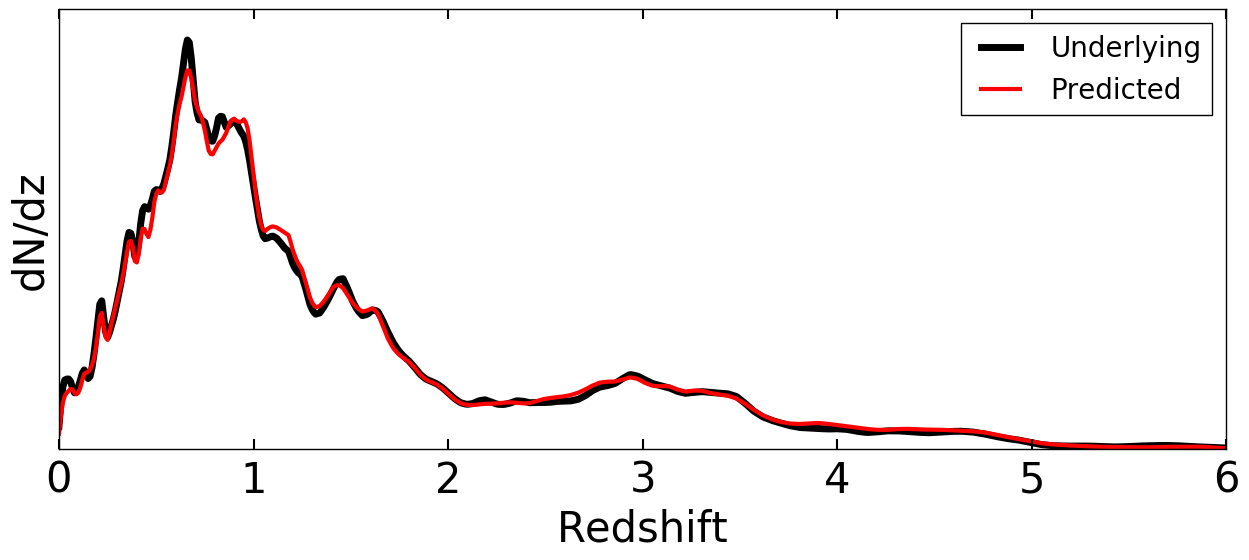

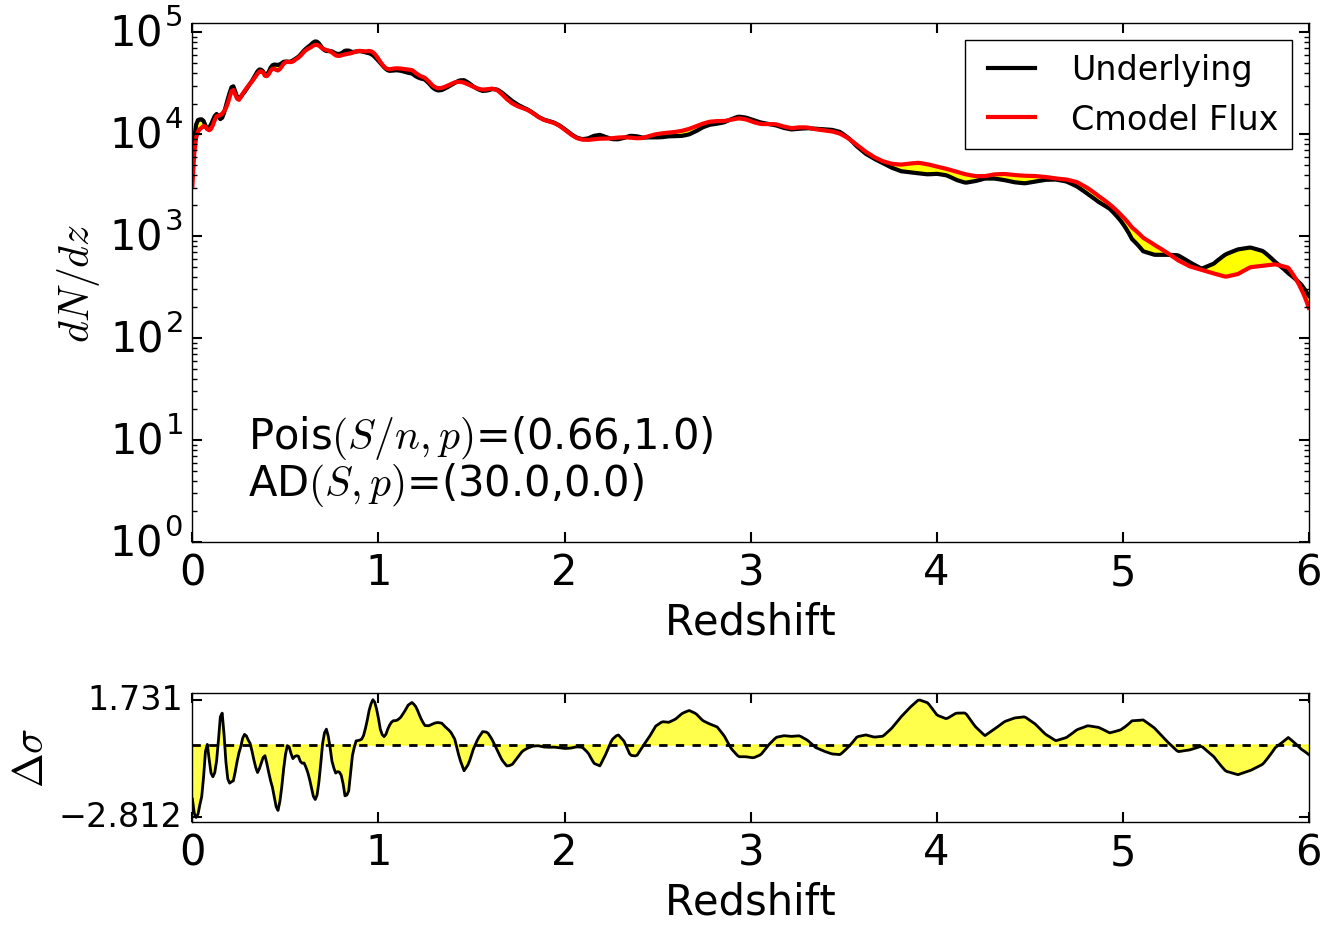

In [21]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Cmodel Flux',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Cmodel Flux'],colors=['black','red'])

### PSF Fluxes

In [22]:
p1,v1,m1=flux_psf[train_sel],square(err_psf_wide[train_sel]),mask_psf[train_sel]
p2,v2,m2=flux_psf[test_sel],square(err_psf_wide[test_sel]),mask_psf[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [23]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                            impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [24]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


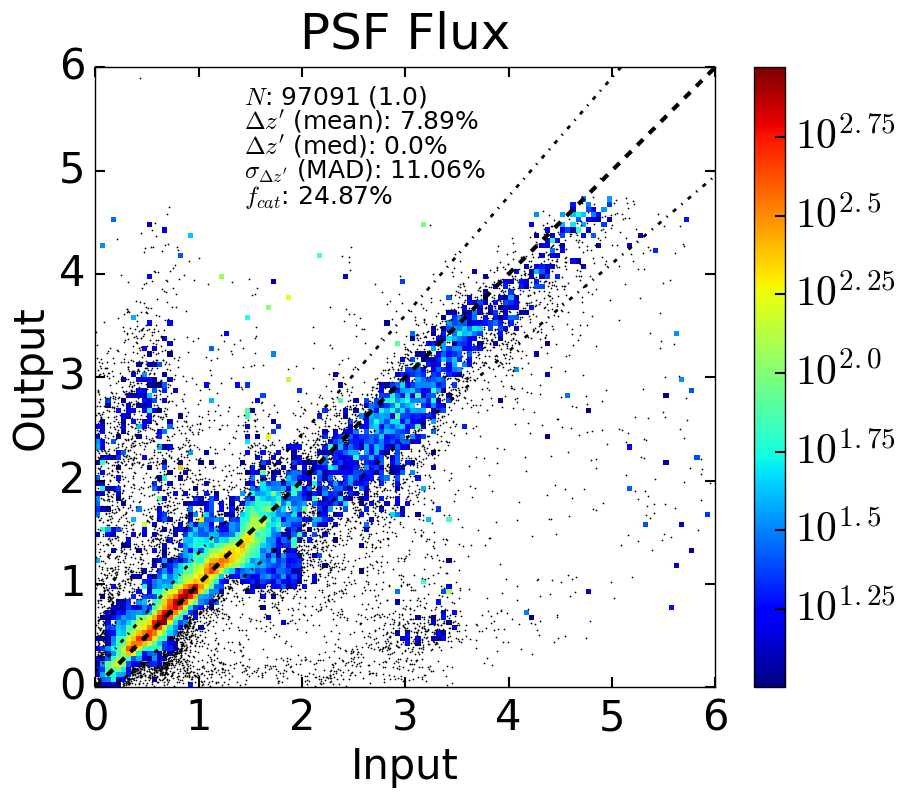

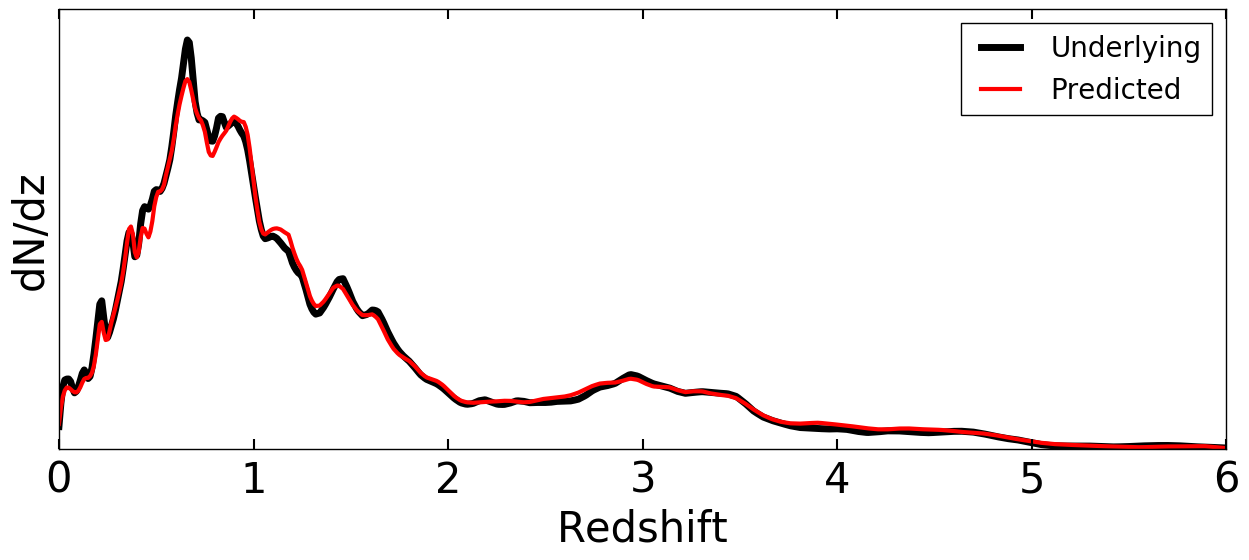

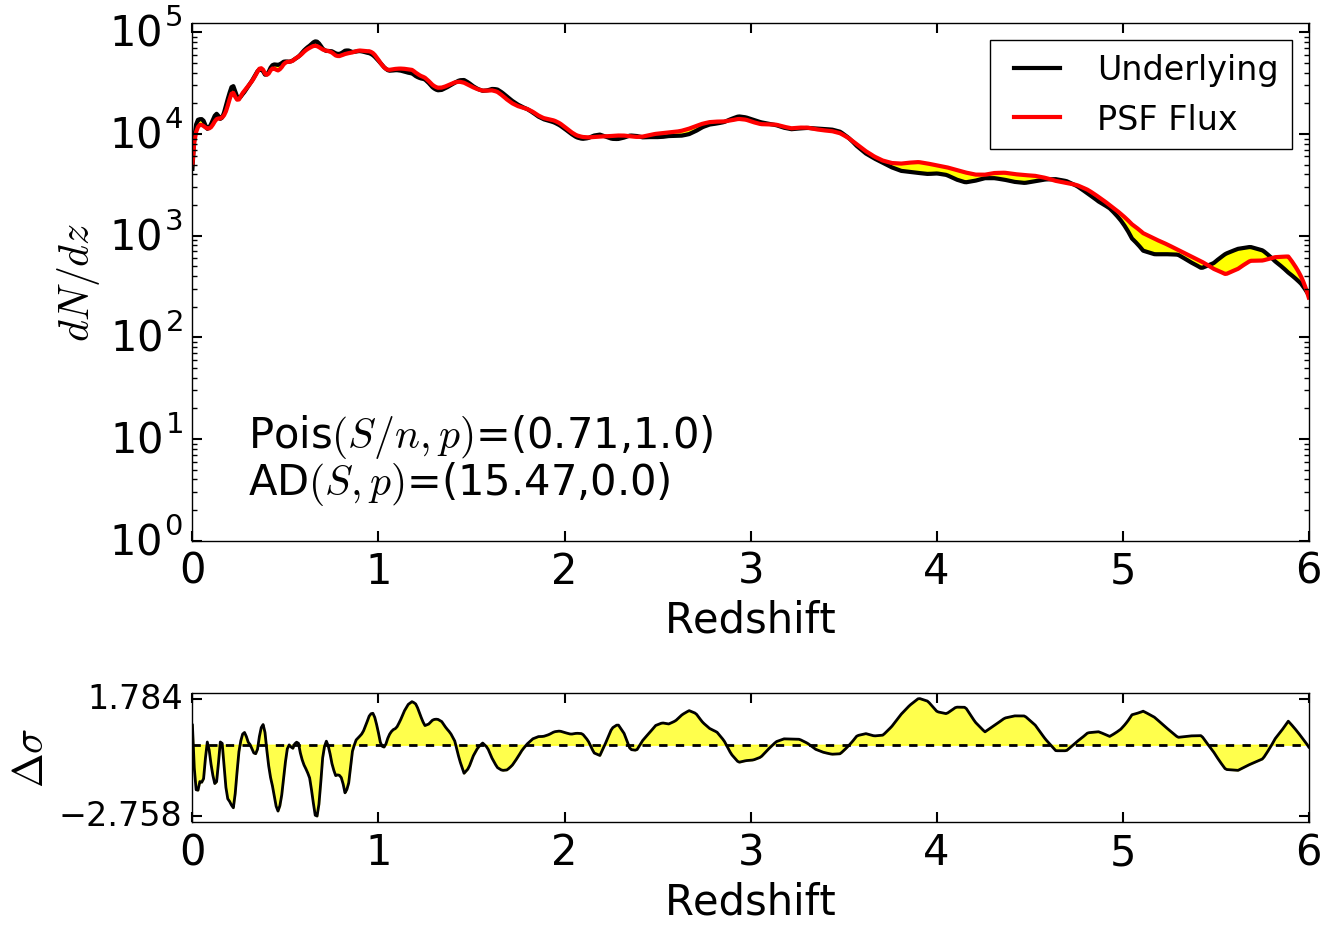

In [25]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('PSF Flux',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','PSF Flux'],colors=['black','red'])

### Cmodel Dev+Exp Fluxes

In [26]:
temp1,temp2=c_[flux_cmodel_dev,flux_cmodel_exp],c_[err_cmodel_dev_wide,err_cmodel_exp_wide]

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),c_[mask_cmodel_dev,mask_cmodel_exp][train_sel]
p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),c_[mask_cmodel_dev,mask_cmodel_exp][test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [27]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


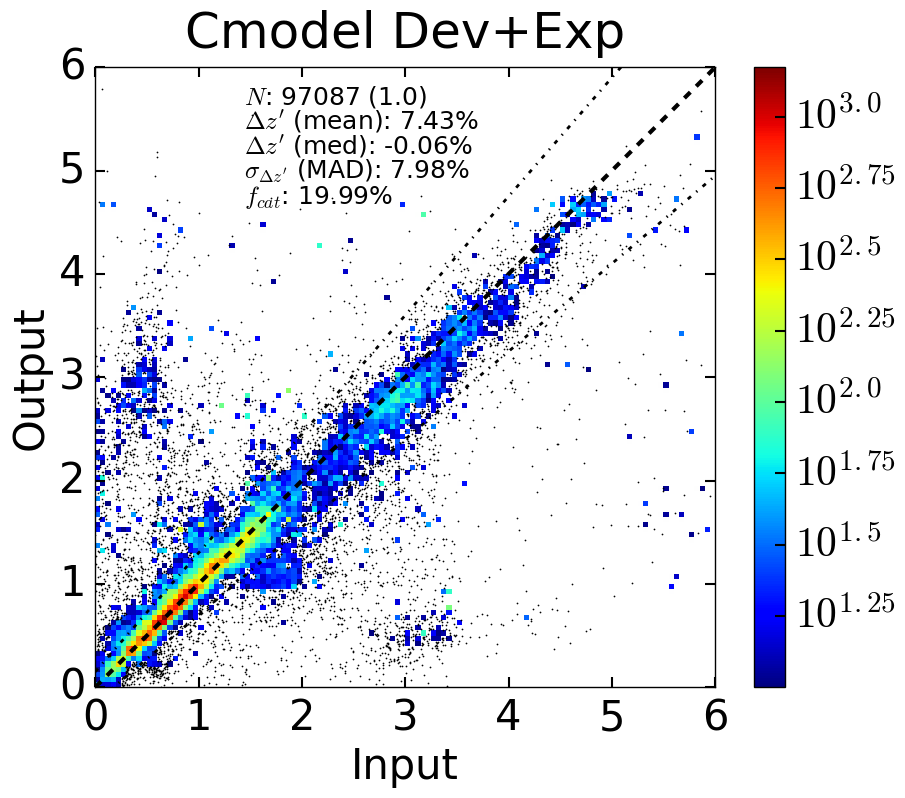

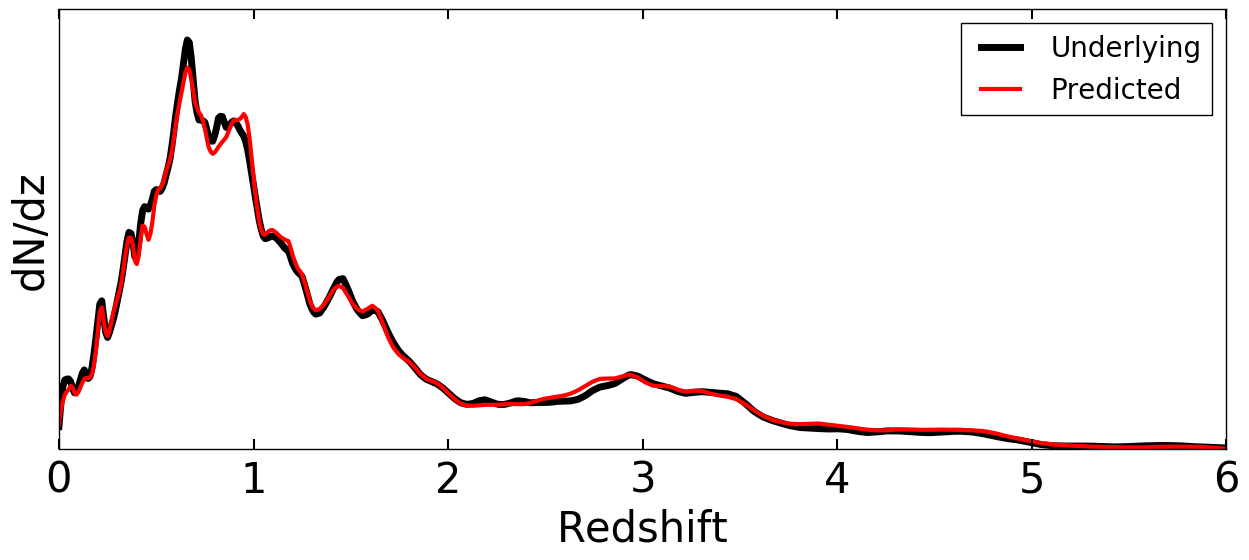

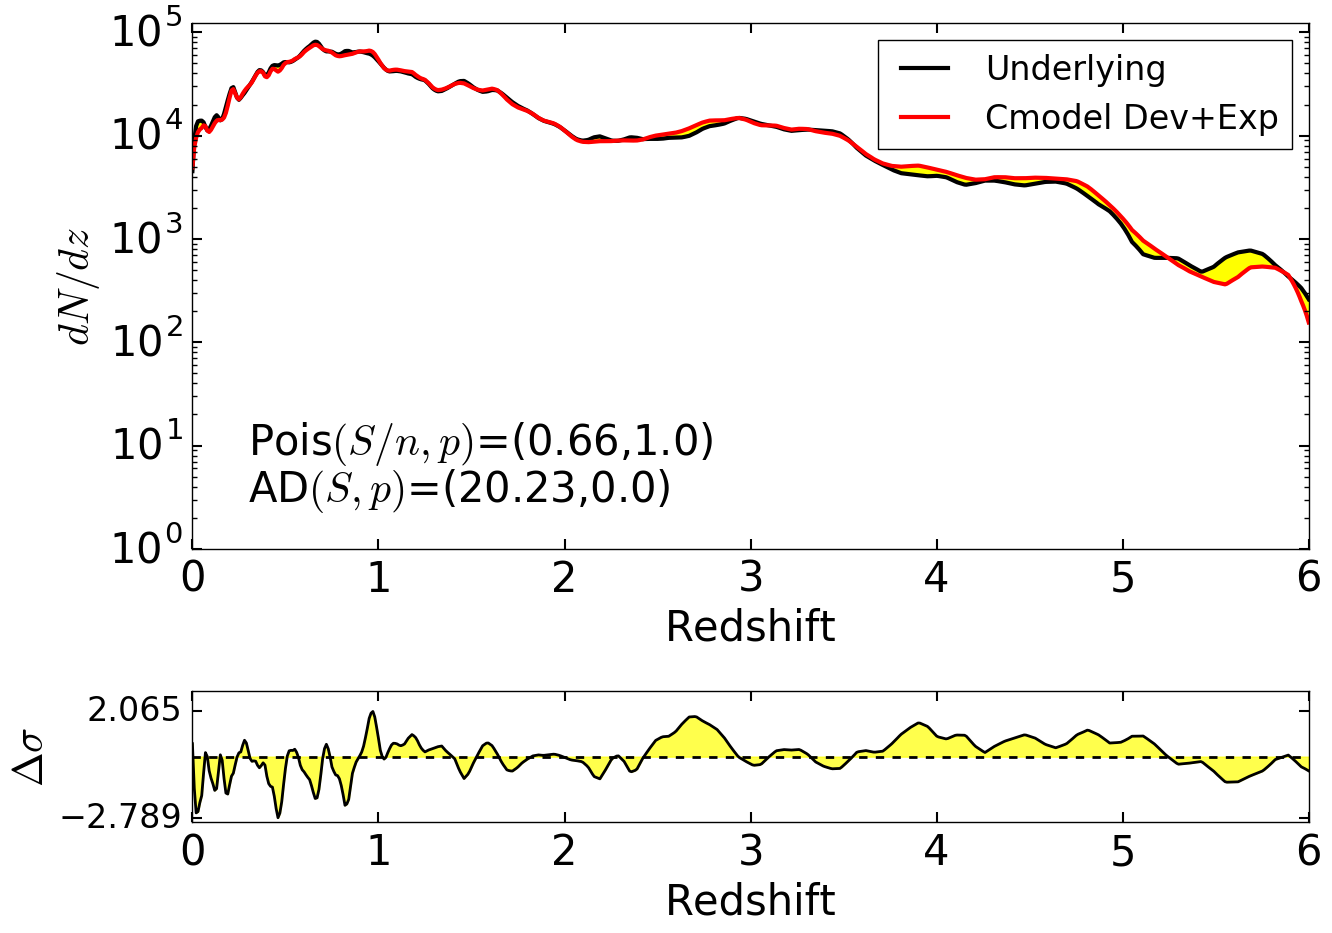

In [28]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Cmodel Dev+Exp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Cmodel Dev+Exp'],colors=['black','red'])

### Afterburner Fluxes

In [29]:
p1,v1,m1=flux_afterburner[train_sel],square(err_afterburner_wide[train_sel]),mask_afterburner[train_sel]
p2,v2,m2=flux_afterburner[test_sel],square(err_afterburner_wide[test_sel]),mask_afterburner[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=skynoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [30]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [31]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


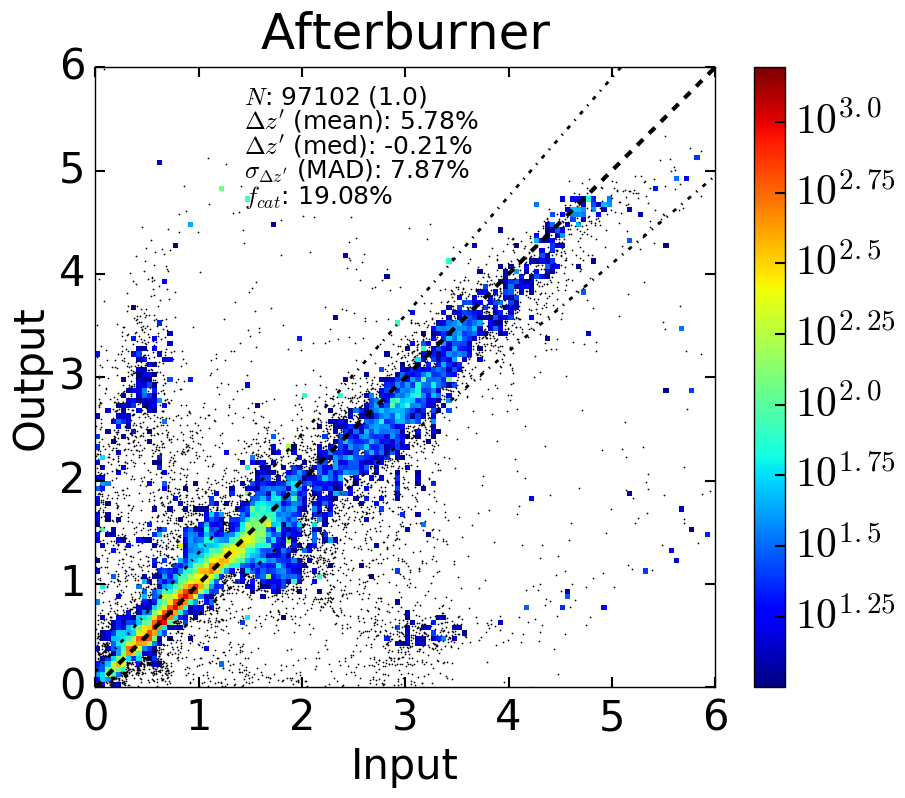

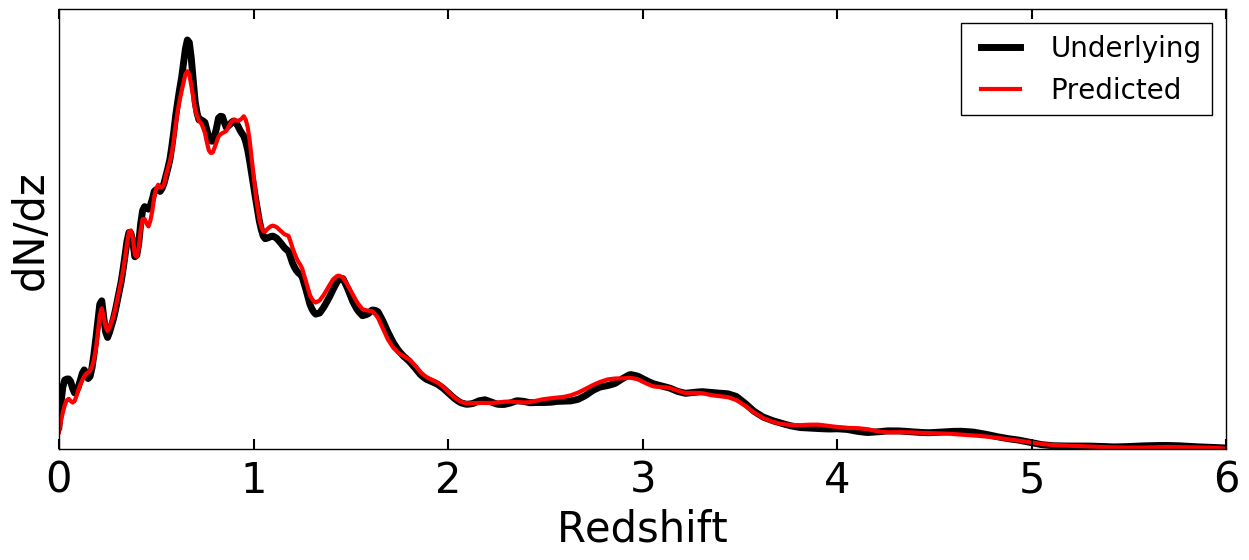

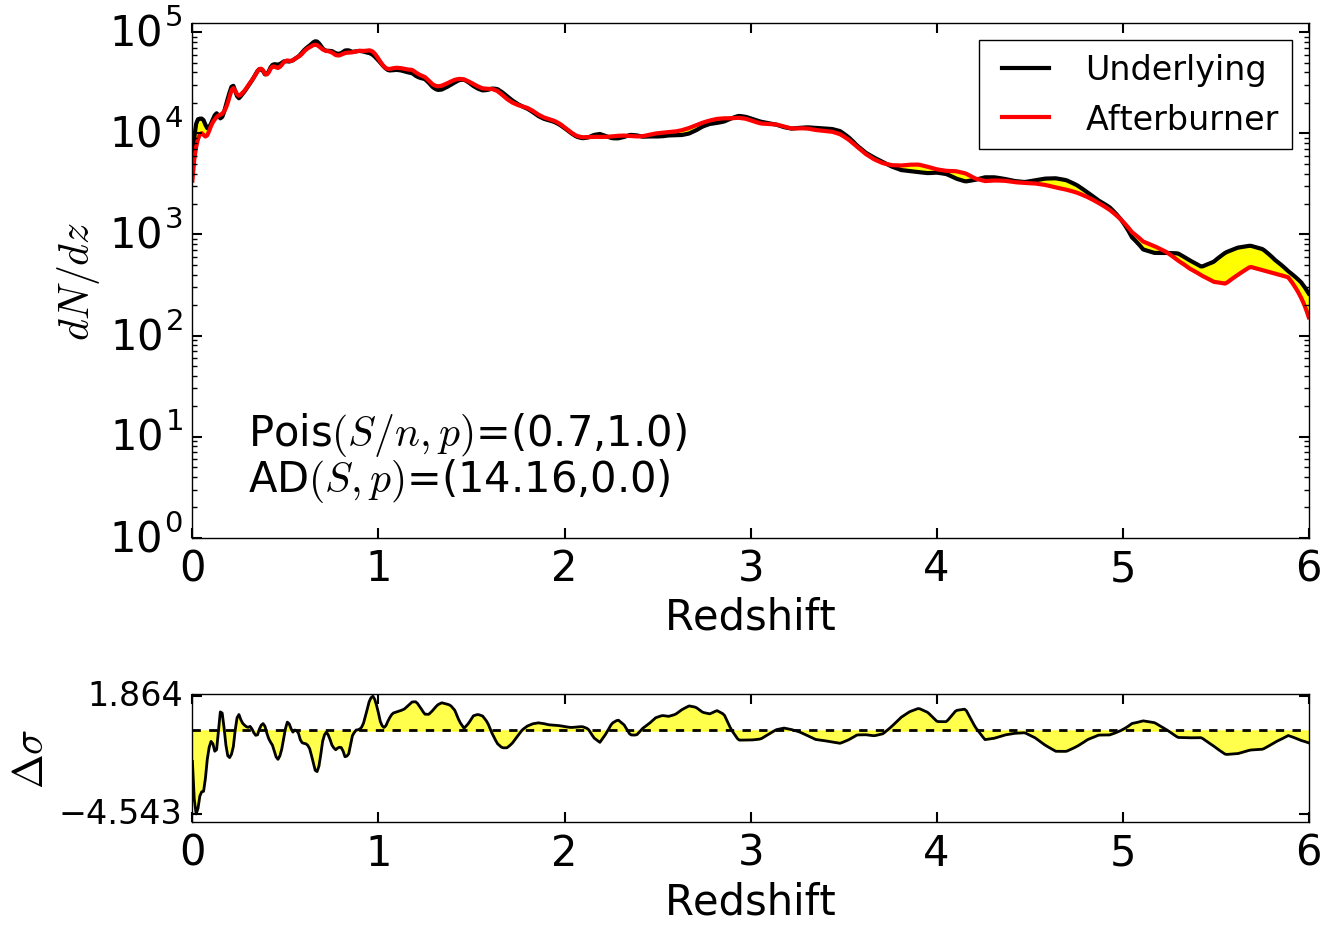

In [32]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Afterburner',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Afterburner'],colors=['black','red'])

## Follow-Up Tests

We notice that performance goes (in order): afterburner flux, cmodel dev+exp flux, cmodel flux, and psf flux. So we'll add together a couple of different fluxes to try and see where performance stops improving (especially since scaling with dimensionality isn't great).

### Aper+Cmodel

In [33]:
temp1,temp2,temp3=c_[flux_afterburner,flux_cmodel],c_[err_afterburner_wide,err_cmodel_wide],c_[mask_afterburner,mask_cmodel]
snoise=array([skynoise for i in xrange(2)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [34]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [35]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


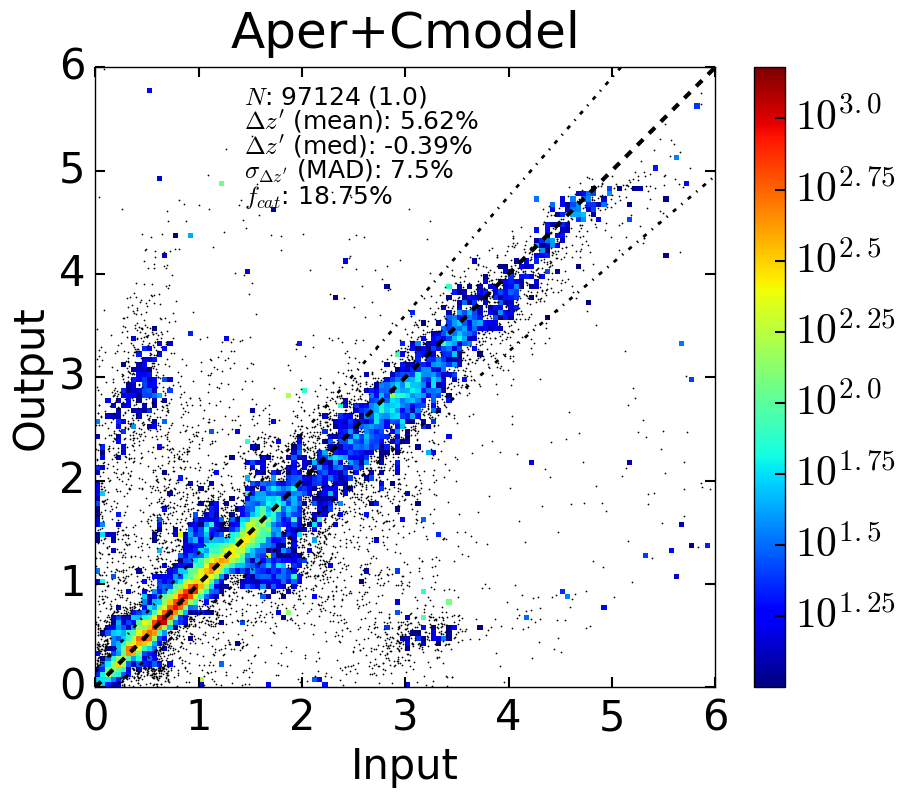

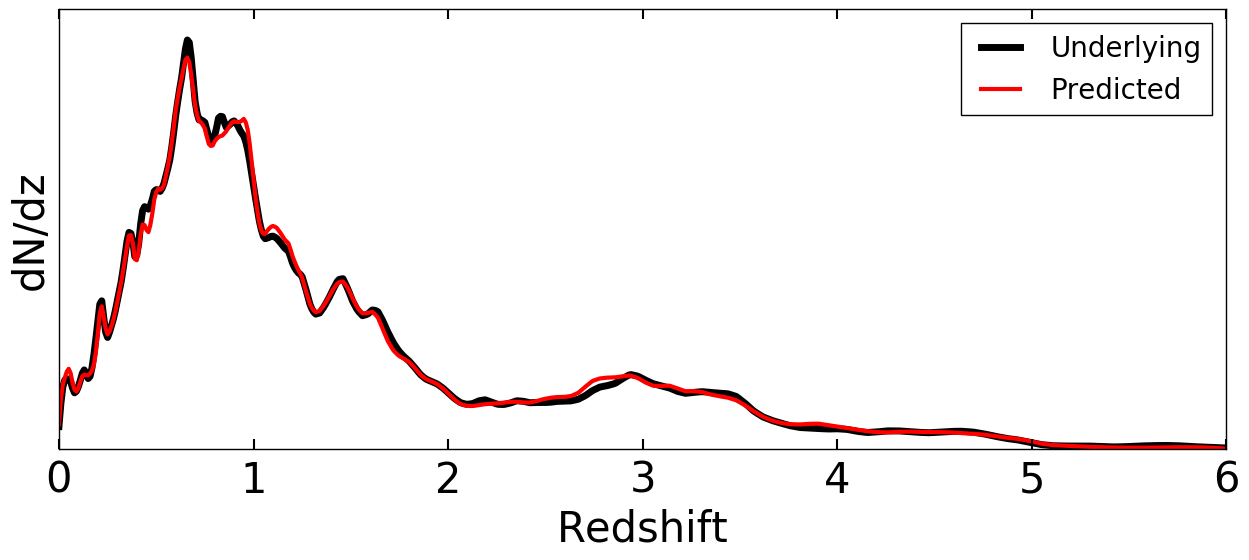

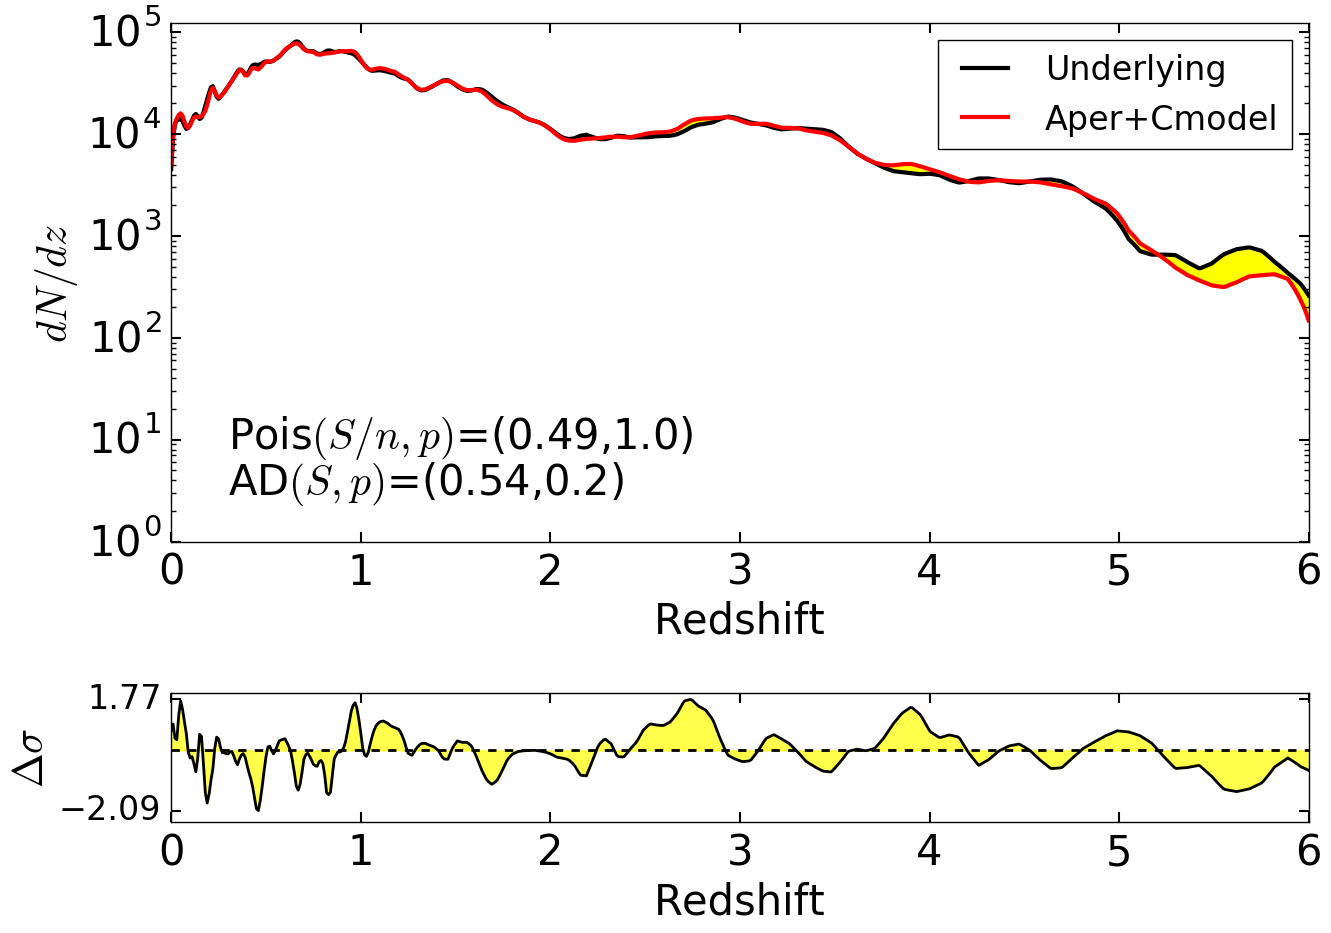

In [36]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cmodel'],colors=['black','red'])

### Aper+Cdev+Cexp

In [37]:
temp1=c_[flux_afterburner,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(3)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [38]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=10,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [39]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


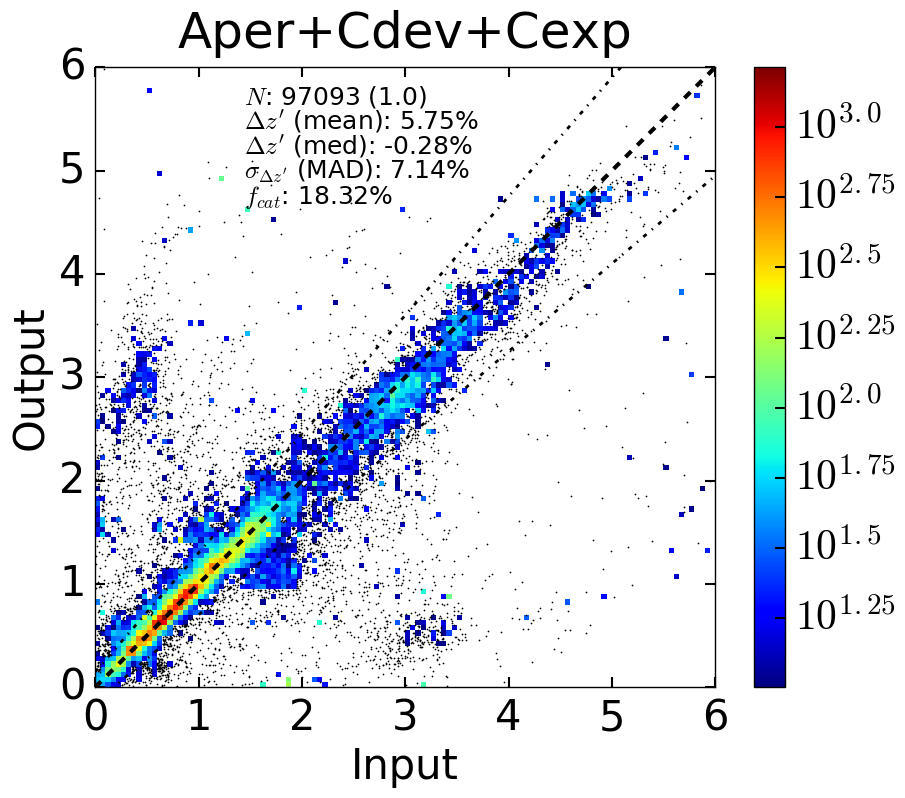

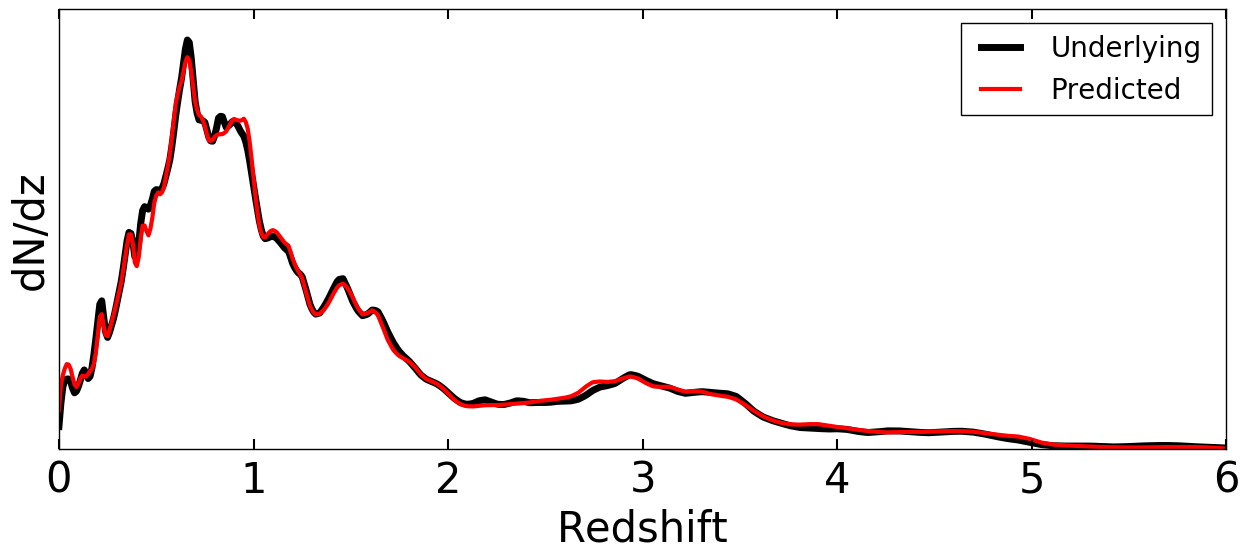

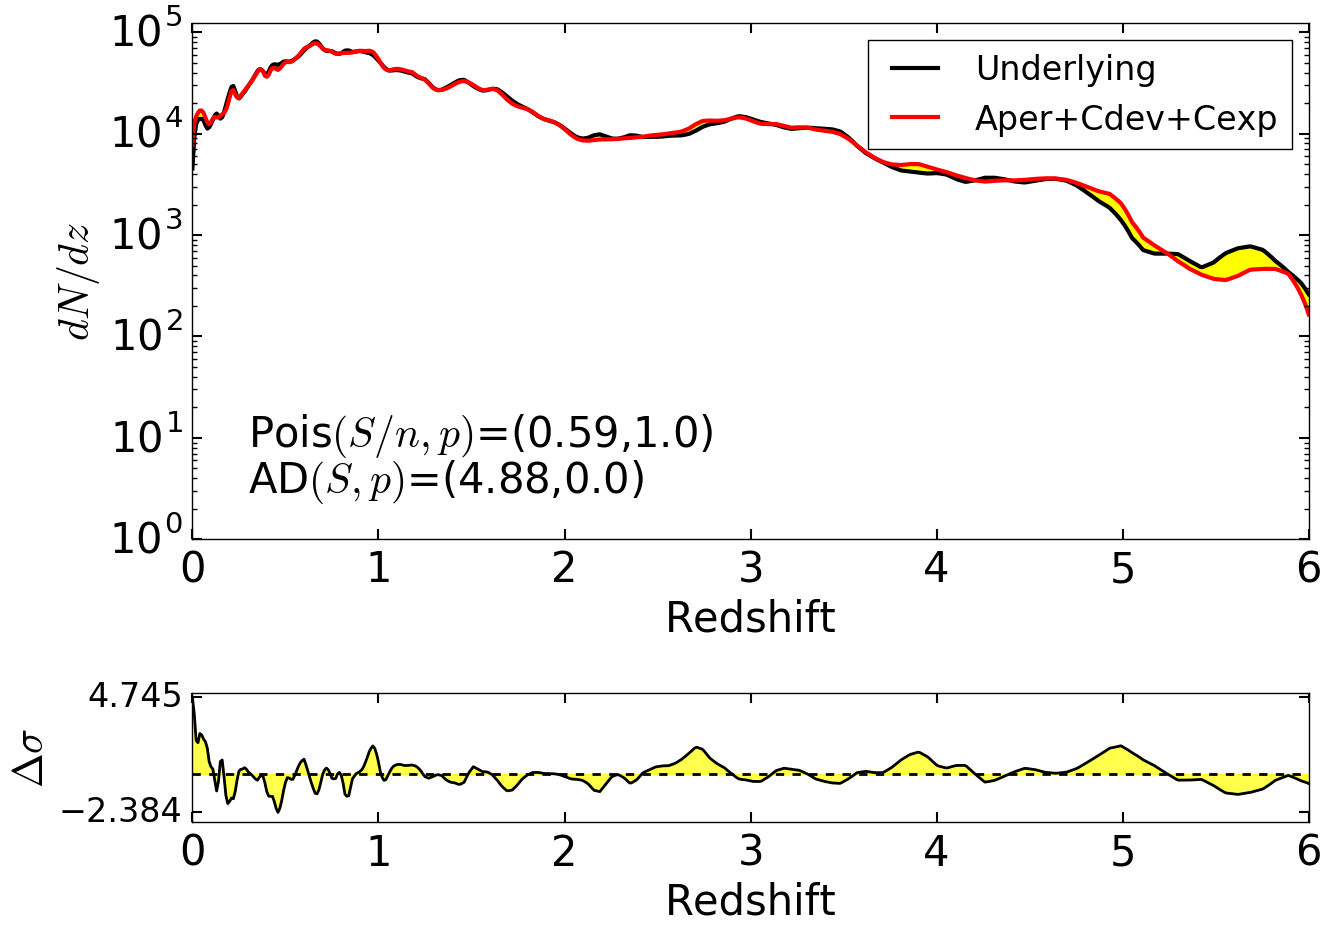

In [40]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cdev+Cexp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cdev+Cexp'],colors=['black','red'])

### Aper+PSF

In [41]:
temp1=c_[flux_afterburner,flux_psf]
temp2=c_[err_afterburner_wide,err_psf_wide]
temp3=c_[mask_afterburner,mask_psf]
snoise=array([skynoise for i in xrange(2)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [42]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [43]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


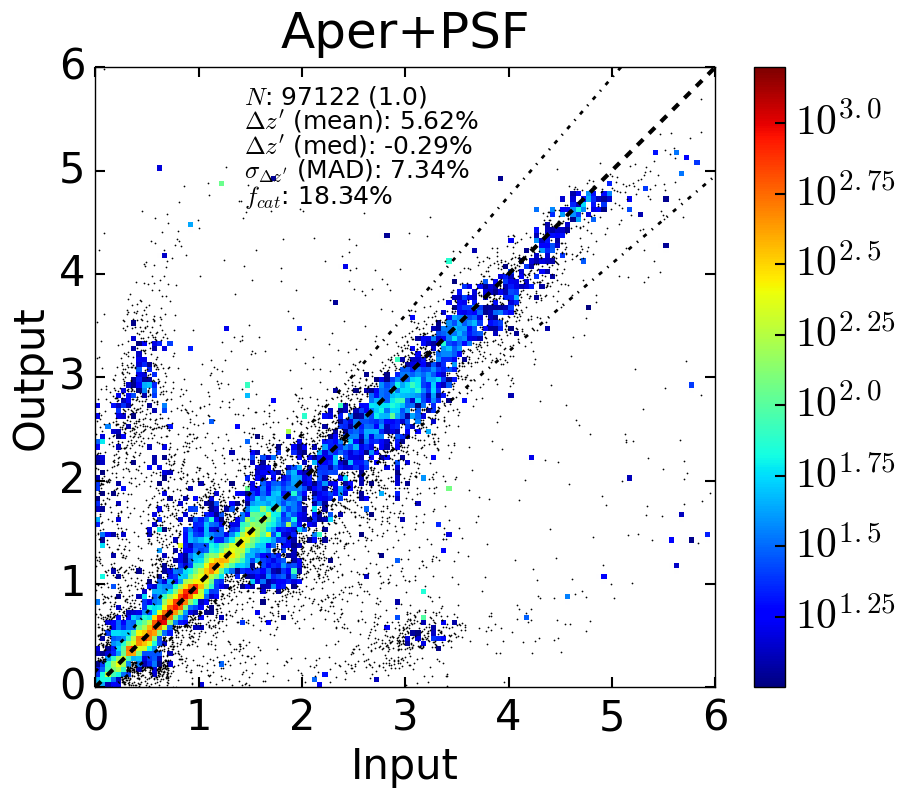

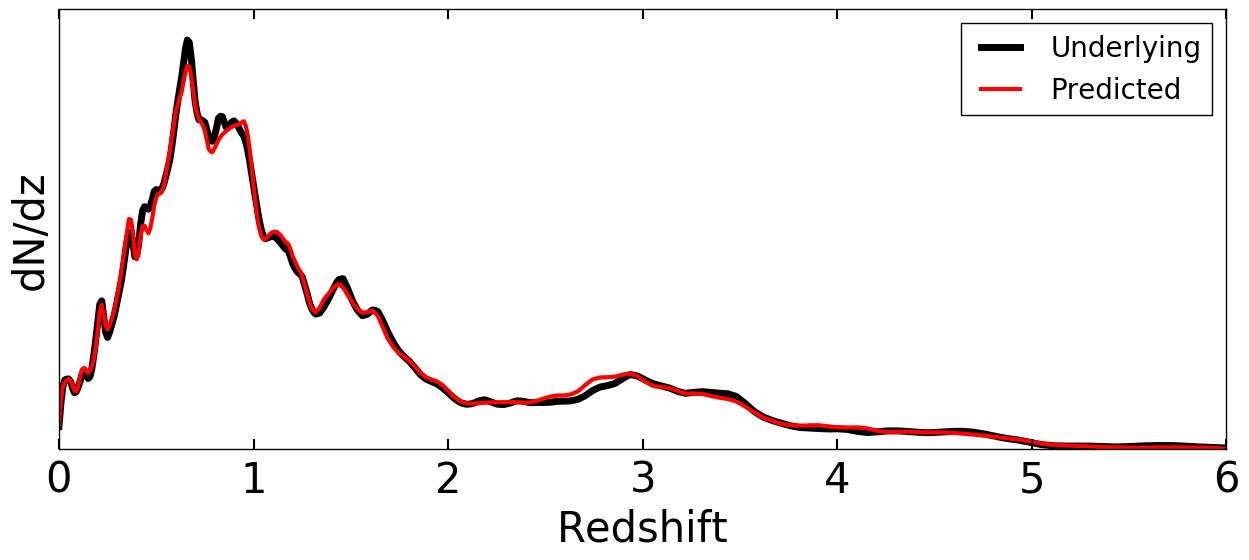

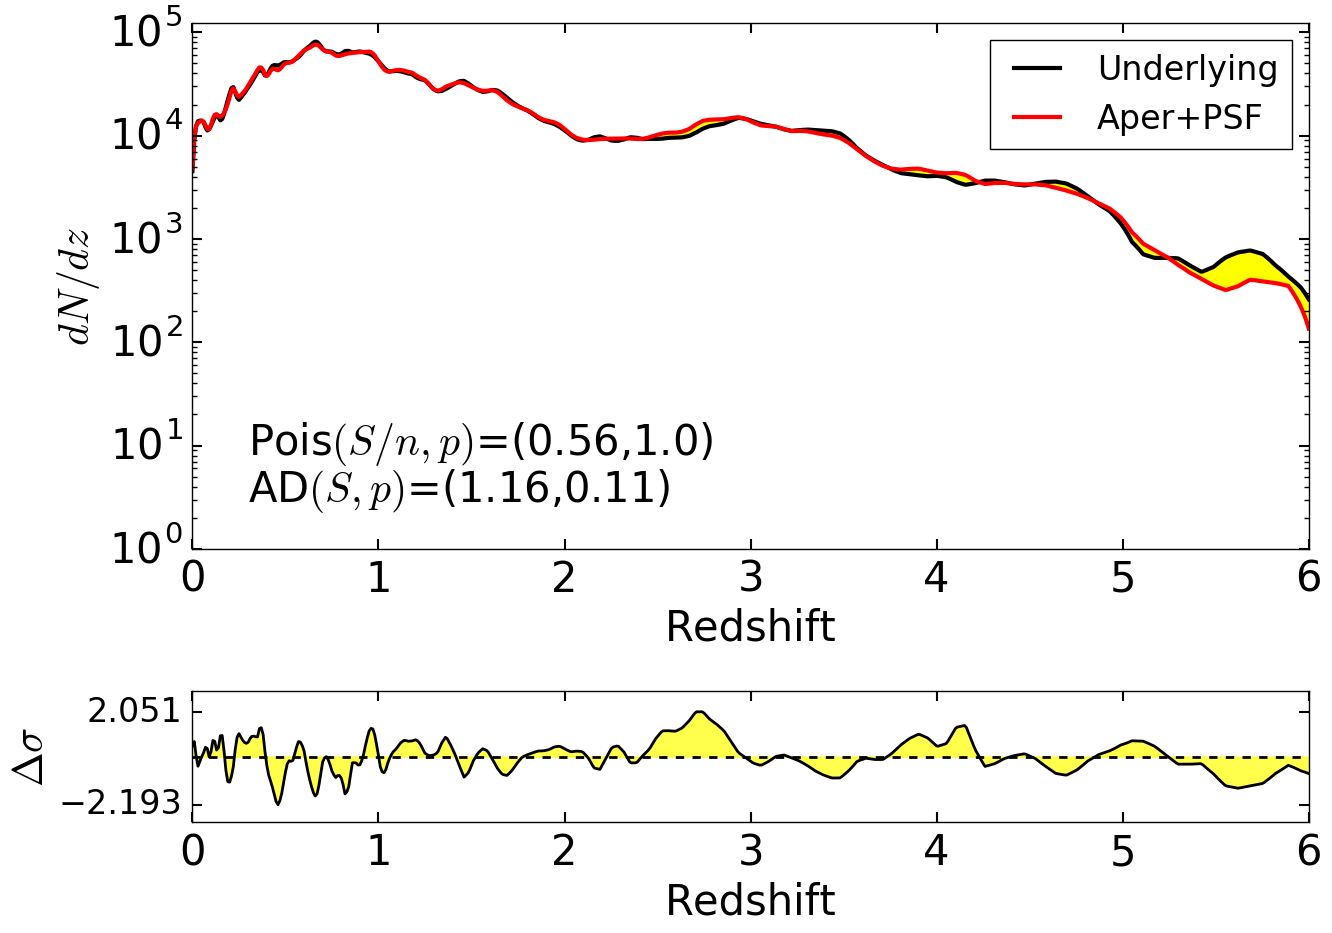

In [44]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF'],colors=['black','red'])

### Aper+PSF+Cdev+Cexp

In [45]:
temp1=c_[flux_afterburner,flux_psf,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner_wide,err_psf_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_psf,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(4)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [46]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=10,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [47]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


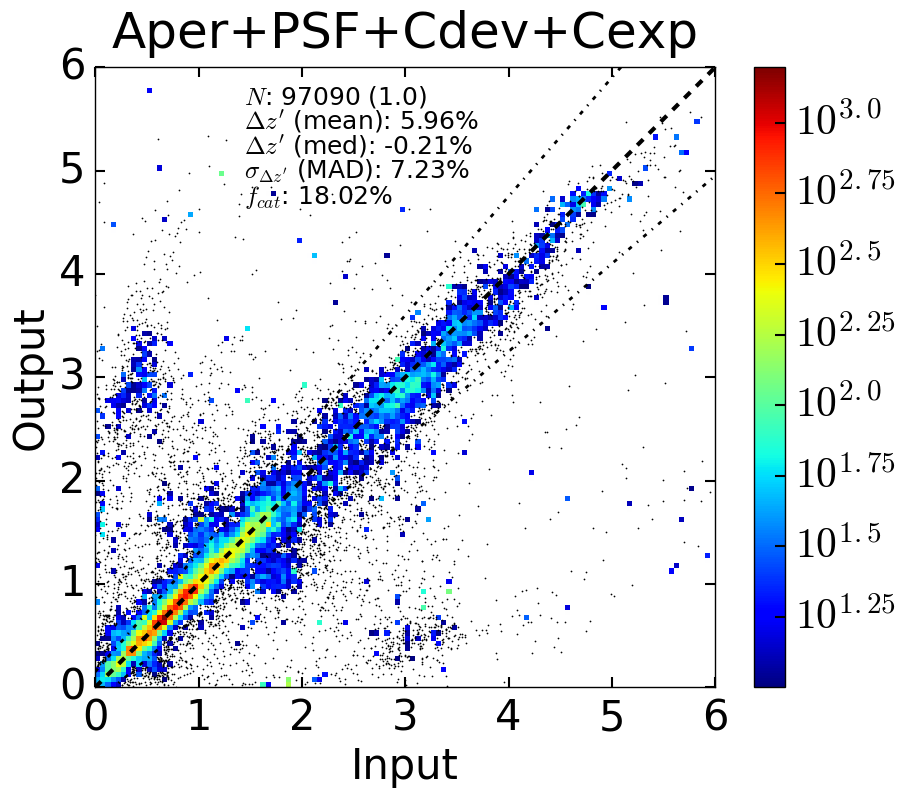

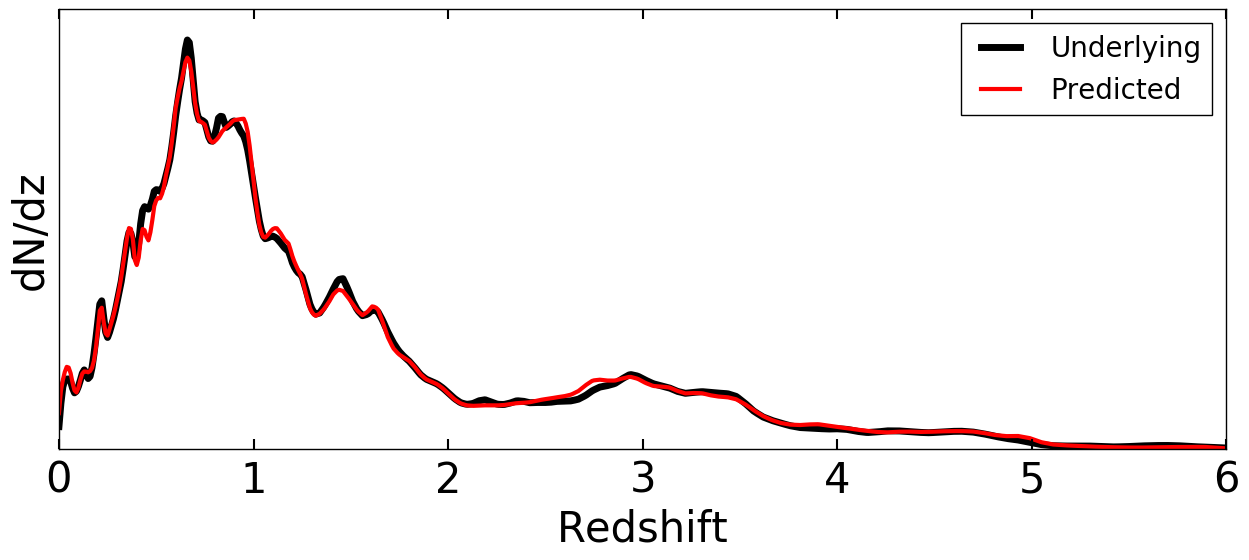

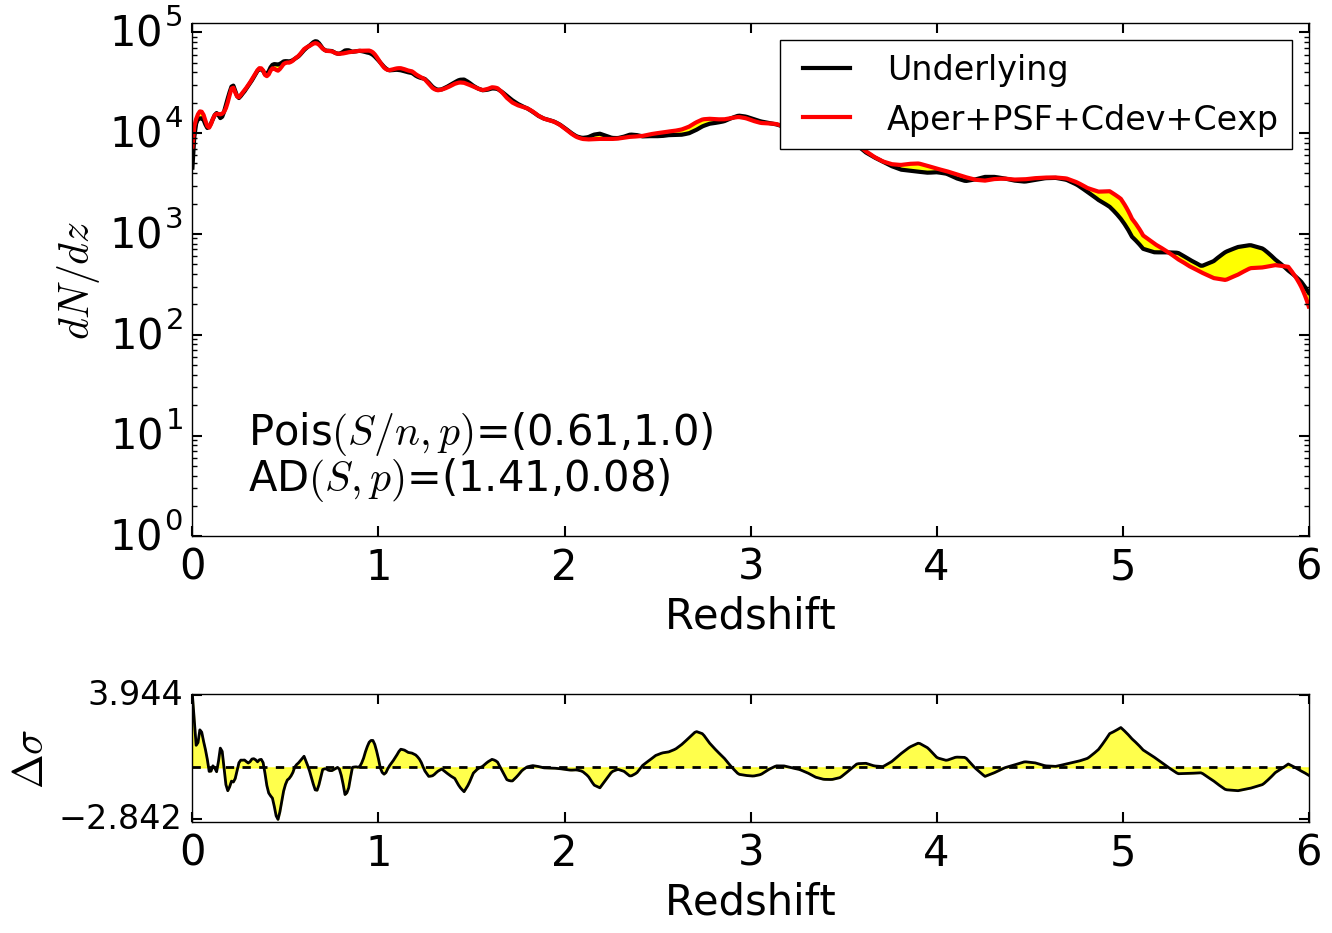

In [48]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF+Cdev+Cexp',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF+Cdev+Cexp'],colors=['black','red'])

### Aper+PSF+Cdev+Cexp+Cmodel

In [49]:
temp1=c_[flux_afterburner,flux_psf,flux_cmodel_dev,flux_cmodel_exp,flux_cmodel]
temp2=c_[err_afterburner_wide,err_psf_wide,err_cmodel_dev_wide,err_cmodel_exp_wide,err_cmodel_wide]
temp3=c_[mask_afterburner,mask_psf,mask_cmodel_dev,mask_cmodel_exp,mask_cmodel]
snoise=array([skynoise for i in xrange(5)]).flatten()

p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),temp3[test_sel]
e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

# initialize WINBET instances
winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET (Ntrees=100,Nleaf=10)
winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
winbet_test.train(p2,v2,m2,mag2,mage2,mdict)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

In [50]:
frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=10,
                                                           impute_train=winbet_train,impute_test=winbet_test)

0 0 0 1 0 0 2 0 0 3 0 0 4 0 0 5 0 0 6 0 0 7 0 0 8 0 0 9 0 0 10 0 0 11 0 0 12 0 0 13 0 0 14 0 0 15 0 0 16 0 0 17 0 0 18 0 0 19 0 0 20 0 0 21 0 0 22 0 0 23 0 0 24 0 0 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


In [51]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf=empty((Ntest,rdict.Nz_out))
model_levidence=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!
Computing PDF quantities...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 done!


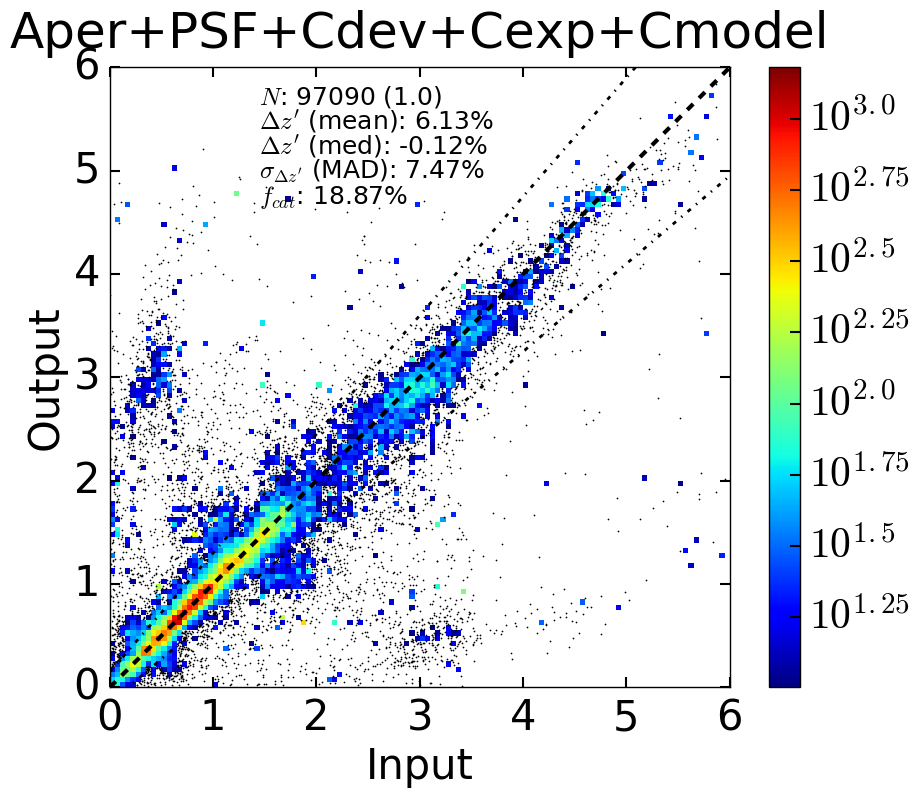

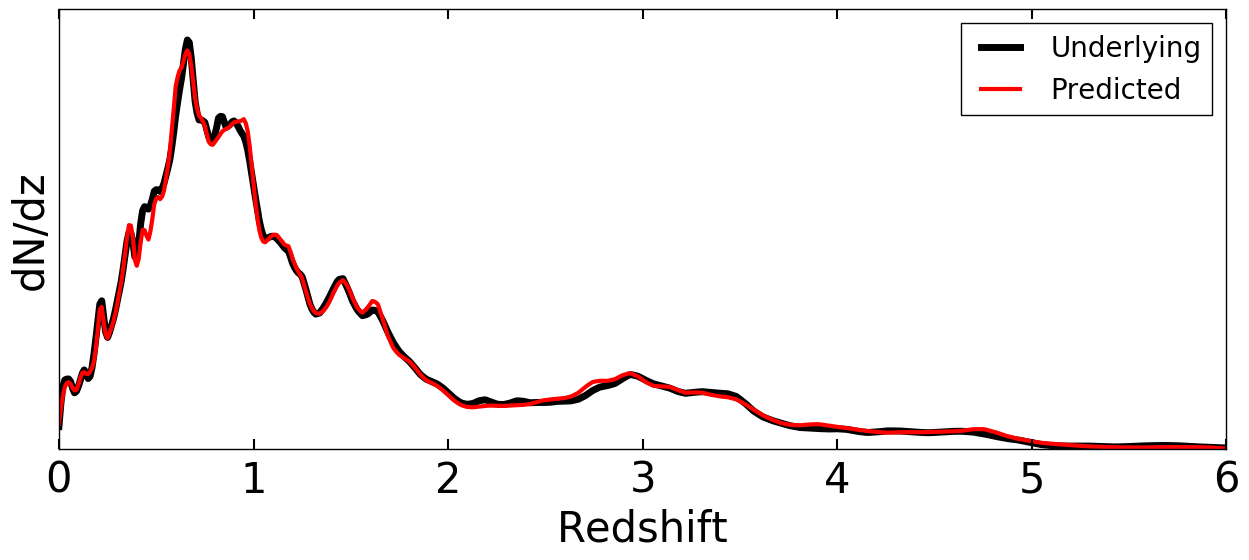

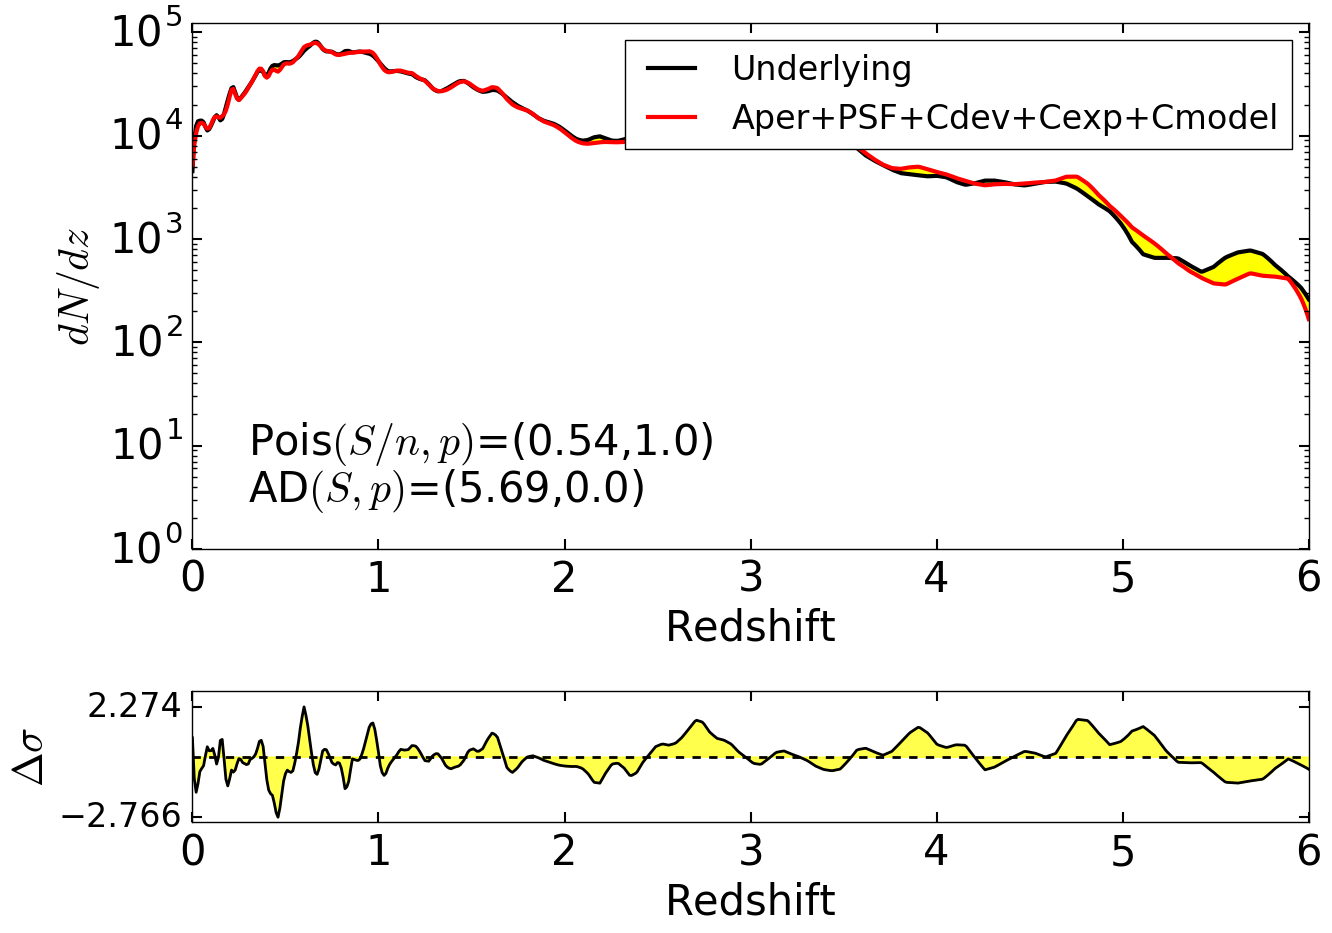

In [52]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+PSF+Cdev+Cexp+Cmodel',z[test_sel],zpoints[1],weights=cv_weights[test_sel])

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test,lzeidx_test,cv_weights[test_sel],
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[test_sel][:,None],axis=0)/cv_weights[test_sel].sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights[test_sel].sum(),nz_stack*cv_weights[test_sel].sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+PSF+Cdev+Cexp+Cmodel'],colors=['black','red'])

## Fiducial Model

We see that the combination of aperture fluxes (from the afterburner) combined with 2-component cmodel photometry performs the best, with the addition of more components not significantly improving the fit (likely because of a combination of adding noise and the increasing restrictiveness of our dimensionality subsampling). We confirm that scaling up to all 15 dimensions does not improve performance, and that we can subsample down to 8 dimensions (slightly more than half) without significant degradation.

In [34]:
temp1=c_[flux_afterburner,flux_cmodel_dev,flux_cmodel_exp]
temp2=c_[err_afterburner_wide,err_cmodel_dev_wide,err_cmodel_exp_wide]
temp3=c_[mask_afterburner,mask_cmodel_dev,mask_cmodel_exp]
snoise=array([skynoise for i in xrange(3)]).flatten()

In [ ]:
model_obj=empty((Nobs,25*10))
model_Nobj=empty(Nobs)
model_ll=empty((Nobs,25*10))
model_Nbands=empty((Nobs,25*10))

for i in xrange(Nfolds):
    sys.stdout.write(str(i)+': ')
    test_sel=cv==(i+1)
    train_sel=(test_sel==False)
    
    p1,v1,m1=temp1[train_sel],square(temp2[train_sel]),temp3[train_sel]
    p2,v2,m2=temp1[test_sel],square(temp2[test_sel]),temp3[test_sel]
    e1,e2=sqrt(v1+square(0.01*p1)),sqrt(v2+square(0.01*p2)) # add 1% error floor

    mag1,mage1=fz.asinh_mag_map(p1,e1,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping
    mag2,mage2=fz.asinh_mag_map(p2,e2,zeropoint=flux_zeropoint,skynoise=snoise) # Luptitude mapping

    # initialize WINBET instances
    winbet_train,winbet_test=fz.WINBET(Ntrees=25),fz.WINBET(Ntrees=25) # intialize WINBET
    if (m1==False).sum()>0:
        winbet_train.train(p1,v1,m1,mag1,mage1,mdict)
    else:
        winbet_train=None
    if (m2==False).sum()>0:
        winbet_test.train(p2,v2,m2,mag2,mage2,mdict)
    else:
        winbet_test=None

    frankenz=fz.FRANKENZ(N_members=25) # default values: N_MC=100, N_neighbors=10
    temp=frankenz.predict(p1,e1,m1,p2,e2,m2,subsample=8,impute_train=winbet_train,impute_test=winbet_test)
    model_obj[test_sel],model_Nobj[test_sel],model_ll[test_sel],model_Nbands[test_sel]=temp

0: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 0 0 1 0 0 2 0 

In [ ]:
# generate redshifts
model_llmin=empty(Nobs).astype(float)
lzpdf=empty((Nobs,rdict.Nz))
zpdf=empty((Nobs,rdict.Nz_out))
model_levidence=empty(Nobs)

for i in xrange(Nobs):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    w=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    model_levidence[i]=-2*log(w.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train[midx],lzeidx_train[midx],w,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

# compute point estimates
zpoints=fz.pdfs_summary_statistics(rdict.zgrid_out,zpdf) # mean, med, mode, l68, h68, l95, h95, std, conf

In [ ]:
# plotting results
figure(figsize=(10,8))
fz.plot_zpoints('Aper+Cdev+Cexp',z,zpoints[1],weights=cv_weights)

figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx,lzeidx,cv_weights,rdict.grid,rdict.delta,rdict.Ngrid)
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

nz_stack=nansum(zpdf*cv_weights[:,None],axis=0)/cv_weights.sum()
plot(rdict.zgrid_out,nz_stack,lw=3,color='red',label='Predicted')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
yticks([])
ylabel('dN/dz')

figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*cv_weights.sum(),nz_stack*cv_weights.sum(),rdict.zgrid_out,rdict.dz_out,
                       sample_names=['Underlying','Aper+Cdev+Cexp'],colors=['black','red'])

STUFF.